In [41]:
import numpy as np
import pandas as pd
import polars as pl
from category_encoders import CatBoostEncoder
from catboost import CatBoostRegressor , Pool, cv
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split


In [42]:
def train_test_split(dataframe, target_colnames, train_ratio = 0.8):
    if type(target_colnames) == str:
        target_colnames = [target_colnames]
    
    assert type(target_colnames) in [str, list]

    shuffled_dataset = dataframe.sample(fraction=1.0, shuffle=True)
    upper_train_index = int(len(shuffled_dataset) * train_ratio)

    train_dataset = shuffled_dataset[:upper_train_index]
    test_dataset = shuffled_dataset[upper_train_index:]

    X_train, y_train = train_dataset.drop(target_colnames), train_dataset.select(target_colnames)
    X_test, y_test = test_dataset.drop(target_colnames), test_dataset.select(target_colnames)

    return X_train.to_pandas(), y_train.to_pandas(), X_test.to_pandas(), y_test.to_pandas()


In [43]:
def ordered_encoding(data, categorical_colnames, target_colname, keep_not_encoded=False):

    def alias_label(col_name):
        return f"{col_name}_encoded" if keep_not_encoded else col_name

    selected_columns = categorical_colnames + [target_colname]

    data_copy = data.select(selected_columns)
    data_copy = data_copy.with_columns(pl.col(categorical_colnames).cast(pl.Utf8))

    cum_sums = [pl.col(target_colname).cum_sum().over(col_name).alias(f"{col_name}_cum_sum") for col_name in categorical_colnames]
    cum_counts = [pl.col(target_colname).cum_count().over(col_name).alias(f"{col_name}_cum_count") - 1 for col_name in categorical_colnames]

    # Perform the aggregation
    temp = data_copy.with_columns(cum_sums + cum_counts)
    temp = temp.with_columns([
        ((pl.col(f"{col_name}_cum_sum") - pl.col(target_colname) + pl.col(target_colname).mean()) 
         / (pl.col(f"{col_name}_cum_count") + 1)).alias(alias_label(col_name)) 
        for col_name in categorical_colnames])
    temp = temp.select([alias_label(col_name) for col_name in categorical_colnames])

    if not keep_not_encoded:
        return data.drop(categorical_colnames).hstack(temp).select(data.columns)
    
    return data.hstack(temp)

In [51]:
def generate_dataset():
    num_samples = 20

    data = pd.DataFrame({
        'Gender': np.random.choice(['Male', 'Female', 'Other'], num_samples),
        'Occupation': np.random.choice(['Doctor', 'Engineer', 'Teacher', 'Artist'], num_samples),
        'Age': np.random.randint(20, 60, num_samples),
        'Income': np.random.randint(30000, 100000, num_samples),
        'Label': np.random.uniform(10000, 40000, num_samples)
    })

    # Define categorical features
    categorical_features = ['Gender', 'Occupation']

    features = data.drop(columns=['Label'])
    targets = data[['Label']]

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

    # return X_train, X_test, y_train, y_test

    return features, targets, data

In [52]:
features, targets, data = generate_dataset()

In [67]:
col = ["Gender", "Occupation"]
# encoder = CatBoostEncoder(cols=col ,return_df=True)
# encoder.fit(features, targets)
# encoder.transform(features, targets)

In [65]:
test_data = pl.from_pandas(data)
ordered_encoding(test_data, col, "Label", keep_not_encoded=True)

Gender,Occupation,Age,Income,Label,Gender_encoded,Occupation_encoded
str,str,i64,i64,f64,f64,f64
"""Male""","""Engineer""",43,60734,39179.013378,24043.786427,24043.786427
"""Female""","""Teacher""",32,83474,32161.747026,24043.786427,24043.786427
"""Female""","""Engineer""",46,61634,10407.246134,28102.766726,31611.399902
"""Female""","""Doctor""",53,47555,18889.198326,22204.259862,24043.786427
"""Other""","""Engineer""",26,35754,17135.012575,24043.786427,24543.348646
…,…,…,…,…,…,…
"""Other""","""Artist""",30,56256,37515.00419,20038.700911,20444.52353
"""Male""","""Doctor""",26,97260,23925.317866,22576.780042,22545.83182
"""Female""","""Teacher""",56,98140,25098.638726,21014.635365,22490.327506


In [66]:
test_data = ordered_encoding(test_data, col, "Label", keep_not_encoded=False)

In [61]:
X_train, y_train, X_test, y_test = train_test_split(test_data, "Label")
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

In [ ]:
# Train CatBoost model
model = CatBoostRegressor(iterations=1, loss_function="RMSE")
# model.fit(train_dataset)

grid = {'iterations': [1],
        'learning_rate': [0.03, 0.1, 0.5, 1],
        'depth': [2, 4, 6, 8, 10, 16, 32],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

model.grid_search(grid, train_pool, verbose=False)

python(19299) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


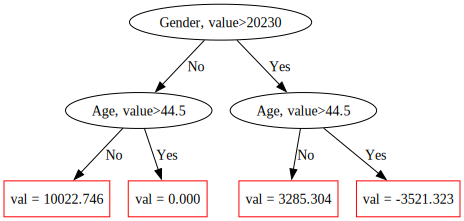

In [63]:
model.plot_tree(tree_idx=0, pool=train_pool)